In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Set date to 2017-08-01, convert it to datetime format
selected_date = pd.to_datetime("2017-08-01").date()
print(selected_date)

2017-08-01


In [11]:
# Calculate the date one year (i.e. 365 days) from the last date in data set.
selected_date_1year_ago = selected_date - dt.timedelta(days=365)
print(selected_date_1year_ago)

2016-08-01


In [12]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
tobs_of_date_range = calc_temps(selected_date_1year_ago, selected_date)
tobs_of_date_range 

[(58.0, 74.64288840262581, 87.0)]

In [13]:
# Create a dataframe to store min, max, average tobs for the given year
tobs_df = []
tobs_df = pd.DataFrame(tobs_of_date_range, columns=["t_min", "t_avg", "t_max"])
tobs_df

,t_min,t_avg,t_max
0,58.0,74.642888,87.0


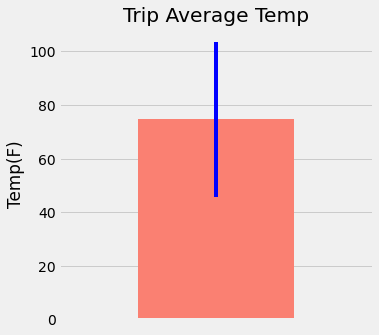

In [14]:
# Plot the results from your previous query as a bar chart. 

plt.figure(figsize=(5,5))

# Calculate the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
err_val = tobs_df["t_max"] - tobs_df["t_min"]

# Use the average temperature for bar height (y value) & plot the average temp graph
ax = tobs_df["t_avg"].plot.bar(yerr=(err_val), color="salmon", ecolor='blue')

# Set graph title and y axis
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)

# Save the graph
plt.savefig("Images/trip_avg_temp.png")
plt.show()

### Daily Rainfall Average

In [15]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# selected_date = 2017-08-01, selected_date_1year_ago = 2016-08-01
q_1year_data=session.query(Measurement.station,Station.name, Station.latitude, Station.longitude, 
                           Station.elevation,func.sum(Measurement.prcp)).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date >=selected_date_1year_ago).\
                filter(Measurement.date <=selected_date).\
                group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()


In [16]:
# Print previous year total amount of rainfall per weather station
df_1year_rain = pd.DataFrame(q_1year_data,columns=['Station','Name','Latitute',
                                                   'Longtitude','Elevation','Total Precipitations'])
df_1year_rain

,Station,Name,Latitute,Longtitude,Elevation,Total Precipitations
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,157.91
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,79.49
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,54.39
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,39.80
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,34.26
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,17.20
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.77


### Daily Temperature Normals

In [17]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [18]:
# Calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Convert the date string into pandas datetime 
sdate = pd.to_datetime(start_date).date()
edate = pd.to_datetime(end_date).date()

# Use the start and end date to create a range of dates. Get the range of date for the trip
date_range= pd.date_range(sdate, edate ,freq='d')

# Strip off the year of the trip's date range and save a list of strings in the format %m-%d
list_dates = []
for i_date in date_range:
    date_string = i_date.strftime("%m-%d")
    list_dates.append(date_string)
    
list_dates

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [19]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for i in list_dates:
    normals.append(daily_normals(i))
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [20]:
# Convert normnals into dataframe
trip_df = pd.DataFrame(sum(normals,[]), columns=['tmin','tavg','tmax'])
trip_df

,tmin,tavg,tmax
0,67.0,75.540000,83.0
1,68.0,75.603774,84.0
2,70.0,76.611111,85.0
3,69.0,76.711538,84.0
4,69.0,76.148148,82.0
5,67.0,76.250000,83.0
6,71.0,77.156863,83.0


In [21]:
# Convert the trip dates' range into a dataframe with dates column as string type
trip_dates = pd.DataFrame(date_range,columns=['Date']).astype(str)

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_daily_normals= []
trip_daily_normals = pd.concat([trip_dates,trip_df],axis=1).set_index(['Date'])
trip_daily_normals

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


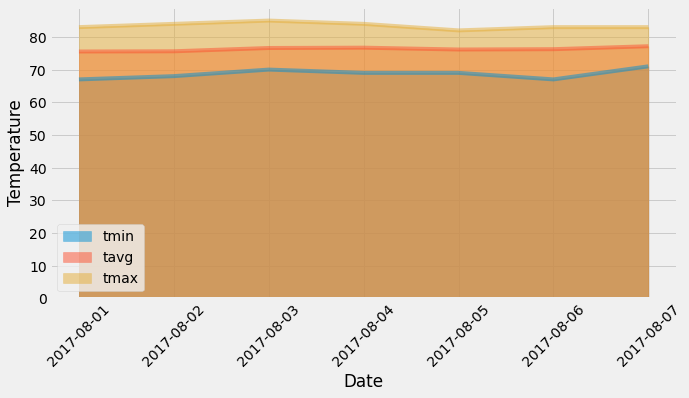

In [22]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_daily_normals.plot.area(stacked=False, figsize=(10,5))
plt.xticks(rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
plt.savefig("Images/trip_normals.png")
plt.show()

## Close Session

In [23]:
# Close Session
session.close()